Import Libraries and Dataset

In [1]:
#Import Analysis Modules
from datetime import datetime
import time

import pandas as pd
from pandas.plotting import scatter_matrix

import numpy as np
from numpy import nan, isnan, mean, std, hstack, ravel

from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, LeavePOut, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Binarizer, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc, accuracy_score,mean_absolute_error, r2_score, roc_auc_score


from scipy.stats import bartlett
from scipy.stats import levene
from statsmodels.tsa.stattools import acf
from scipy.stats import jarque_bera
from scipy.stats import normaltest
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from statsmodels.tools.eval_measures import mse, rmse

#Import Visualization Modules
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
%matplotlib inline

#Import SciPy
from scipy.sparse import issparse

#Import warning
import warnings
warnings.simplefilter("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## Read in file
data = pd.read_csv('https://media.githubusercontent.com/media/apham15/large_csv/main/loan.csv',delimiter='~}',na_values='nan',)

Understand the data

In [3]:
## Count of instances and features
rows, columns = data.shape
print(data.shape)

(42535, 112)


In [4]:
data.info

<bound method DataFrame.info of             id  member_id  ...  total_il_high_credit_limit  Unnamed: 111
0      1077501    1296599  ...                         NaN           NaN
1      1077430    1314167  ...                         NaN           NaN
2      1077175    1313524  ...                         NaN           NaN
3      1076863    1277178  ...                         NaN           NaN
4      1075358    1311748  ...                         NaN           NaN
...        ...        ...  ...                         ...           ...
42530    73582      73096  ...                         NaN           NaN
42531    72998      72992  ...                         NaN           NaN
42532    72176      70868  ...                         NaN           NaN
42533    71623      70735  ...                         NaN           NaN
42534    70686      70681  ...                         NaN           NaN

[42535 rows x 112 columns]>

In [5]:
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,Unnamed: 111
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,f,0.0,0.0,1008.710000,1008.71,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [6]:
## Get basic statistics for continuous features
numeric = data.describe(include=['number']).T.reset_index()
numeric.rename(columns={'index':'feature'},inplace=True)
numeric.insert(1,'missing',(rows - numeric['count'])/ float(rows))
numeric

,feature,missing,count,mean,std,min,25%,50%,75%,max
0,id,0.0,42535.0,664579.852310,219302.219319,54734.0,498392.5,644250.0,825822.5,1077501.0
1,member_id,0.0,42535.0,825702.551170,279540.905635,70473.0,638479.5,824178.0,1033946.5,1314167.0
2,loan_amnt,0.0,42535.0,11089.722581,7410.938391,500.0,5200.0,9700.0,15000.0,35000.0
3,funded_amnt,0.0,42535.0,10821.585753,7146.914675,500.0,5000.0,9600.0,15000.0,35000.0
4,funded_amnt_inv,0.0,42535.0,10139.830603,7131.686446,0.0,4950.0,8500.0,14000.0,35000.0
...,...,...,...,...,...,...,...,...,...,...
83,tot_hi_cred_lim,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,total_bal_ex_mort,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,total_bc_limit,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,total_il_high_credit_limit,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Distribution of Loan Status in our Dataset')

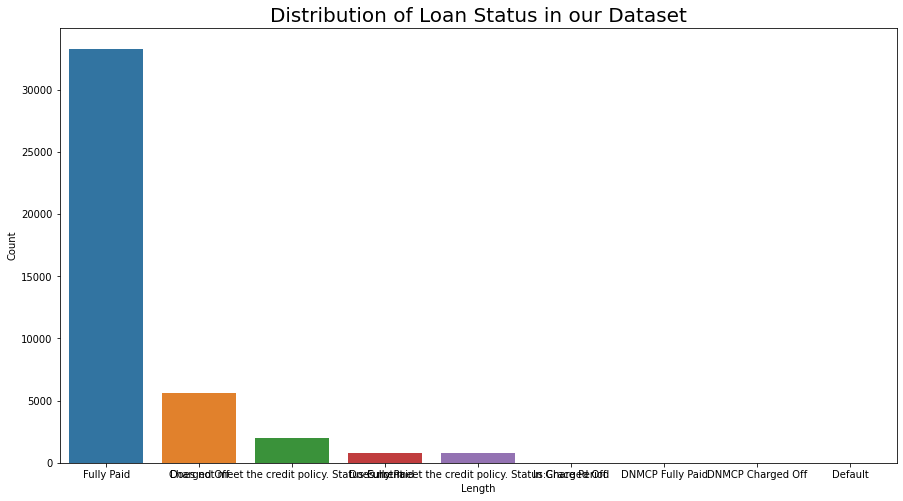

In [7]:
## Understand of distribution of Loan Status in put Dataset
m = data['loan_status'].value_counts()
m = pd.DataFrame(m)
m.reset_index(level=0, inplace=True)

m['index'][6] = "DNMCP Fully Paid"
m['index'][7] = "DNMCP Charged Off"
m
m.columns = ['Loan Status','Count']
plt.subplots(figsize=(15,8))
sns.barplot(y='Count', x='Loan Status', data=m)
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Loan Status in our Dataset", fontsize=20)


Text(0.5, 1.0, 'Knowing what is in side of the Loan Status')

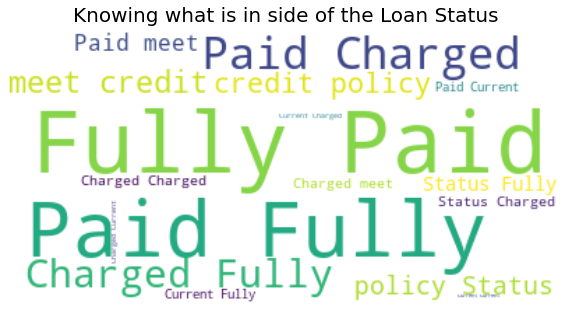

In [8]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(" ".join(data["loan_status"]))
plt.figure(figsize=(10,7))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Knowing what is in side of the Loan Status", fontsize=20)


Text(0.5, 1.0, 'Amount Distribuition Loan Amount')

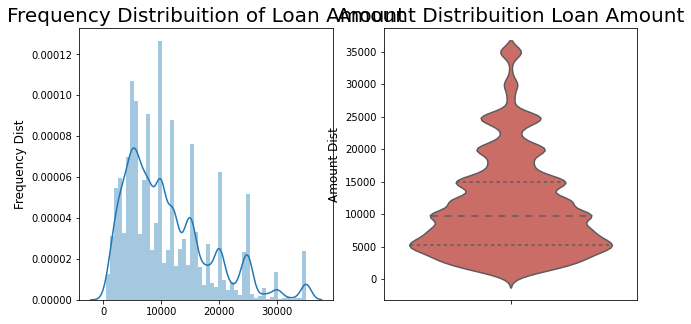

In [9]:
## Understand the distribution
plt.figure(figsize=(10,5))

plt.subplot(121)
g = sns.distplot(data["loan_amnt"])
g.set_xlabel("", fontsize=12)
g.set_ylabel("Frequency Dist", fontsize=12)
g.set_title("Frequency Distribuition of Loan Amount", fontsize=20)

plt.subplot(122)
g1 = sns.violinplot(y="loan_amnt", data=data, 
               inner="quartile", palette="hls")
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Amount Dist", fontsize=12)
g1.set_title("Amount Distribuition Loan Amount", fontsize=20)

In [10]:
#adjust interest rate format
data['int_rate'] = data[['int_rate']].applymap(lambda x:str(x).rstrip('%'))
data['int_rate'] = data['int_rate'].astype('float64')

No handles with labels found to put in legend.


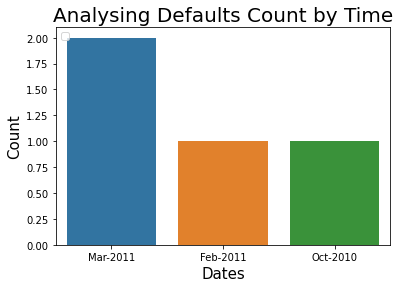

In [11]:
#Looking the count of defaults though the issue_d that is The month which the loan was funded
g = sns.countplot(x='issue_d', data=data[data['loan_status'] =='Default'])
g.set_xticklabels(g.get_xticklabels(),rotation=0)
g.set_xlabel("Dates", fontsize=15)
g.set_ylabel("Count", fontsize=15)
g.legend(loc='upper left')
g.set_title("Analysing Defaults Count by Time", fontsize=20)
plt.show()

Text(0.5, 1.0, 'Evaluation of loan status with loan grade and verified status')

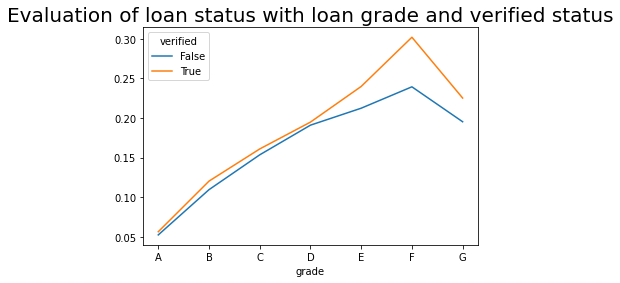

In [12]:
data['verified'] = data['verification_status'] == 'Verified'
grade_yr_loanamnt = pd.pivot_table(data,index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default = pd.pivot_table(data[(data.loan_status == 'Charged Off') | (data.loan_status == 'Default')],
                                           index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default.columns = ['Charged_off']

loan_verified = pd.merge(grade_yr_loanamnt, grade_yr_loanamnt_default, left_index = True, right_index = True)
loan_verified['chargeoff_rate']  = loan_verified['Charged_off'] /  loan_verified['loan_amnt'] 

loan_verified_unstack = loan_verified.unstack("verified")
verified_chargedoff = loan_verified_unstack['chargeoff_rate']
verified_chargedoff.plot()
plt.title("Evaluation of loan status with loan grade and verified status", fontsize=20)

Text(0.5, 1.0, 'Total committed by Investors')

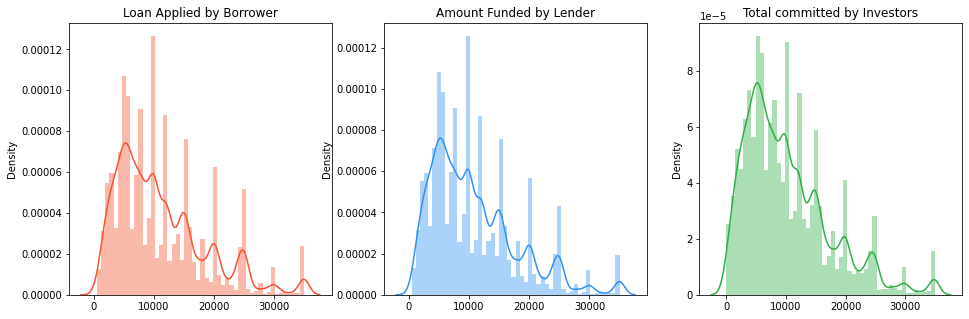

In [13]:
ig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = data["loan_amnt"].values
funded_amount = data["funded_amnt"].values
investor_funds = data["funded_amnt_inv"].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by Borrower", fontsize=12)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by Lender", fontsize=12)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=12)

Most of the loans issued were in the range of 5,000 to 14,000. The loans applied by potential borrowers, the amount issued to the borrowers and the amount funded by investors are similarly distributed, meaning that it is most likely that qualified borrowers are going to get the loan they had applied for.

count    42535.000000
mean     10139.830603
std       7131.686446
min          0.000000
25%       4950.000000
50%       8500.000000
75%      14000.000000
max      35000.000000
Name: funded_amnt_inv, dtype: float64

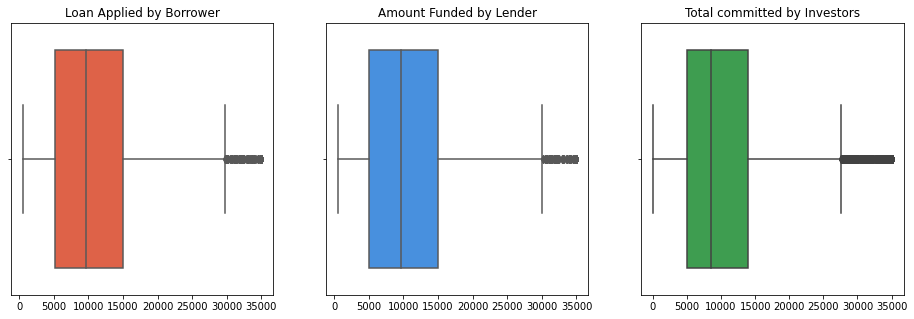

In [14]:
ig, ax = plt.subplots(1, 3, figsize=(16,5))

loan_amount = data["loan_amnt"].values
funded_amount = data["funded_amnt"].values
investor_funds = data["funded_amnt_inv"].values

sns.boxplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by Borrower", fontsize=12)
sns.boxplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by Lender", fontsize=12)
sns.boxplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=12)

data['funded_amnt_inv'].describe()

In [15]:
# Remove rows which have loan status as current as our target column values are Fully Paid and Charged Off
df = data.loc[(data.loan_status != 'Current'), :]
# Determining the loans that are bad from loan_status column

bad_loan = ["Charged Off", "Default", "Does not meet the credit policy. Status:Charged Off", "In Grace Period", 
            "Late (16-30 days)", "Late (31-120 days)"]


df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'
    
    
df['loan_condition'] = df['loan_status'].apply(loan_condition)

Text(0, 0.5, '% of Loan Status')

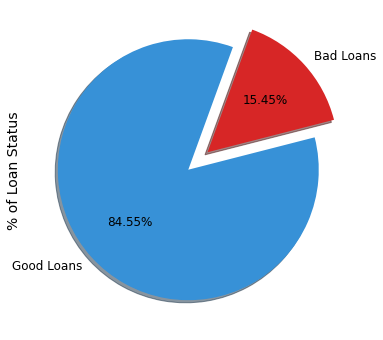

In [16]:
plt.figure(figsize=(12, 6))
colors = ["#3791D7", "#D72626"]
labels = "Good Loans", "Bad Loans"
df["loan_condition"].value_counts().plot.pie(explode=[0,0.2], autopct='%1.2f%%', shadow=True, colors=colors, labels=labels, fontsize=12, startangle=70)
plt.ylabel('% of Loan Status', fontsize=14)


Fully paid or good loans consist 84.55% of total loans in the cleaned data frame.

Charged off or bad loans consist 15.45% of total loans in the cleaned data frame.

term
 36 months    31534
 60 months    10220
Name: loan_condition, dtype: int64


[Text(0, 0.5, 'Count of Loans'), Text(0.5, 0, 'Term in months')]

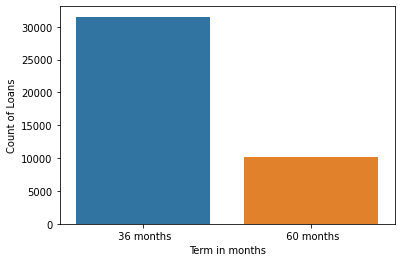

In [17]:
print(df.groupby("term").loan_condition.count())


ax1 = sns.countplot(x="term", data = df)
ax1.set(xlabel='Term in months', ylabel="Count of Loans")

Most of the loan are 36 months

**After taking a look on dataset, I decided to have more insightful information about loan status with other features that have an impact on loan status. Let's clean the data and eliminate the unneccessary columns.**

Cleaning data

In [18]:
## How many features can we eliminate?
drop = numeric[(numeric['missing']==1) | (numeric['std']==0)]
drop

,feature,missing,count,mean,std,min,25%,50%,75%,max
26,collections_12_mths_ex_med,0.003409,42390.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,mths_since_last_major_derog,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,policy_code,0.000000,42535.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
29,annual_inc_joint,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,dti_joint,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,verification_status_joint,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,tot_coll_amt,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,tot_cur_bal,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,open_acc_6m,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,open_il_6m,1.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
## Drop the unhelpful features from the base and numeric table
data = data.drop(drop['feature'],axis=1)
numeric = numeric[~numeric['feature'].isin(drop['feature'])]

In [20]:
## Double check data
data.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,application_type,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,f,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jul-2016,INDIVIDUAL,0.0,0.0,0.0,0.0,True
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,INDIVIDUAL,0.0,0.0,0.0,0.0,False
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,f,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jul-2016,INDIVIDUAL,0.0,0.0,0.0,0.0,False


In [21]:
## Double check numeric
numeric

,feature,missing,count,mean,std,min,25%,50%,75%,max
0,id,0.000000,42535.0,664579.852310,219302.219319,54734.00,498392.500000,644250.000000,8.258225e+05,1.077501e+06
1,member_id,0.000000,42535.0,825702.551170,279540.905635,70473.00,638479.500000,824178.000000,1.033946e+06,1.314167e+06
2,loan_amnt,0.000000,42535.0,11089.722581,7410.938391,500.00,5200.000000,9700.000000,1.500000e+04,3.500000e+04
3,funded_amnt,0.000000,42535.0,10821.585753,7146.914675,500.00,5000.000000,9600.000000,1.500000e+04,3.500000e+04
4,funded_amnt_inv,0.000000,42535.0,10139.830603,7131.686446,0.00,4950.000000,8500.000000,1.400000e+04,3.500000e+04
5,installment,0.000000,42535.0,322.623063,208.927216,15.67,165.520000,277.690000,4.281800e+02,1.305190e+03
6,annual_inc,0.000094,42531.0,69136.556420,64096.349719,1896.00,40000.000000,59000.000000,8.250000e+04,6.000000e+06
7,dti,0.000000,42535.0,13.373043,6.726315,0.00,8.200000,13.470000,1.868000e+01,2.999000e+01
8,delinq_2yrs,0.000682,42506.0,0.152449,0.512406,0.00,0.000000,0.000000,0.000000e+00,1.300000e+01
9,inq_last_6mths,0.000682,42506.0,1.081424,1.527455,0.00,0.000000,1.000000,2.000000e+00,3.300000e+01


In [22]:
## Get basic statistics for discrete features
discrete = data.describe(include=['object']).T.reset_index()
discrete.rename(columns={'index':'feature'},inplace=True)
discrete.insert(1,'missing',(rows - discrete['count'])/ float(rows))
discrete

,feature,missing,count,unique,top,freq
0,term,0,42535,2,36 months,31534
1,grade,0,42535,7,B,12389
2,sub_grade,0,42535,35,B3,2997
3,emp_title,0.0617374,39909,30658,US Army,139
4,emp_length,0.0261432,41423,11,10+ years,9369
5,home_ownership,0,42535,5,RENT,20181
6,verification_status,0,42535,3,Not Verified,18758
7,issue_d,0,42535,55,Dec-2011,2267
8,loan_status,0,42535,9,Fully Paid,33314
9,pymnt_plan,0,42535,2,n,42534


In [23]:
## How many features can we eliminate?
ddrop = discrete[(discrete['missing']>.6) | (discrete['unique']==1)]
ddrop

,feature,missing,count,unique,top,freq
18,initial_list_status,0,42535,1,f,42535
20,next_pymnt_d,0.915811,3581,102,Aug-2016,642
22,application_type,0,42535,1,INDIVIDUAL,42535


In [24]:
## Drop unhelpful features from the base table
data = data.drop(ddrop['feature'],axis=1)
discrete = discrete[~discrete['feature'].isin(ddrop['feature'])]
data

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-2015,171.62,Jul-2016,0.0,0.0,0.0,0.0,True
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-2013,119.66,Sep-2013,0.0,0.0,0.0,0.0,False
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-2014,649.91,Jul-2016,0.0,0.0,0.0,0.0,False
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-1996,1.0,35.0,NaN,10.0,0.0,5598,21%,37.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-2015,357.48,Apr-2016,0.0,0.0,0.0,0.0,False
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-2011,Current,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-1996,0.0,38.0,NaN,15.0,0.0,27783,53.9%,38.0,335.1,335.1,3716.700000,3716.70,2664.90,1051.80,0.00,0.00,0.00,Aug-2016,67.79,Jul-2016,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42530,73582,73096,3500,3500,225.0,36 months,10.28,113.39,C,C1,NaN,< 1 year,RENT,180000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,I am getting married on July 28 and will need ...,other,Wedding coming up,100xx,NY,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,3719.431070,239.11,3500.00,219.43,0.00,0.00,0.00,Mar-2008,0.00,Feb-2013,NaN,NaN,NaN,NaN,False
42531,72998,72992,1000,1000,0.0,36 months,9.64,32.11,B,B4,Halping hands company inc.,< 1 year,RENT,12000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,I would like to buy some new furniture in my a...,other,delight,021xx,MA,10.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,1155.600899,0.00,1000.00,155.60,0.00,0.00,0.00,Jun-2010,32.41,Sep-2014,NaN,NaN,NaN,NaN,False
42532,72176,70868,2525,2525,225.0,36 months,9.33,80.69,B,B3,NaN,< 1 year,RENT,110000.0,Not Verified,Jun-2007,Does not meet the credit policy. Status:Fully ...,n,https://lendingclub.com/browse/loanDetail.acti...,

In [25]:
##double check discrete
discrete

,feature,missing,count,unique,top,freq
0,term,0,42535,2,36 months,31534
1,grade,0,42535,7,B,12389
2,sub_grade,0,42535,35,B3,2997
3,emp_title,0.0617374,39909,30658,US Army,139
4,emp_length,0.0261432,41423,11,10+ years,9369
5,home_ownership,0,42535,5,RENT,20181
6,verification_status,0,42535,3,Not Verified,18758
7,issue_d,0,42535,55,Dec-2011,2267
8,loan_status,0,42535,9,Fully Paid,33314
9,pymnt_plan,0,42535,2,n,42534


In [26]:
## Discrete remove
data = data.drop(['grade','sub_grade','int_rate','emp_title','issue_d','pymnt_plan','url','desc','title','earliest_cr_line','last_pymnt_d','last_credit_pull_d'],axis=1)

In [27]:
data = data.drop(['id','member_id'],axis=1)

In [28]:
data.shape

(42535, 38)

In [29]:
## Keep only those loan status where fully paid or charged off
data = data[data['loan_status'].isin(['Fully Paid','Charged Off'])]
#check data
data

,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,5000,5000,4975.0,36 months,162.87,10+ years,RENT,24000.0,Verified,Fully Paid,credit_card,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7%,9.0,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,171.62,0.0,0.0,0.0,0.0,True
1,2500,2500,2500.0,60 months,59.83,< 1 year,RENT,30000.0,Source Verified,Charged Off,car,309xx,GA,1.00,0.0,5.0,NaN,NaN,3.0,0.0,1687,9.4%,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,0.0,0.0,0.0,0.0,False
2,2400,2400,2400.0,36 months,84.33,10+ years,RENT,12252.0,Not Verified,Fully Paid,small_business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5%,10.0,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,649.91,0.0,0.0,0.0,0.0,False
3,10000,10000,10000.0,36 months,339.31,10+ years,RENT,49200.0,Source Verified,Fully Paid,other,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21%,37.0,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,357.48,0.0,0.0,0.0,0.0,False
5,5000,5000,5000.0,36 months,156.46,3 years,RENT,36000.0,Source Verified,Fully Paid,wedding,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3%,12.0,0.0,0.0,5632.210000,5632.21,5000.00,632.21,0.00,0.00,0.00,161.03,0.0,0.0,0.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39781,2500,2500,1075.0,36 months,78.42,4 years,MORTGAGE,110000.0,Not Verified,Fully Paid,home_improvement,802xx,CO,11.33,0.0,0.0,0.0,0.0,13.0,0.0,7274,13.1%,40.0,0.0,0.0,2822.969293,1213.88,2500.00,322.97,0.00,0.00,0.00,80.90,0.0,0.0,NaN,NaN,False
39782,8500,8500,875.0,36 months,275.38,3 years,RENT,18000.0,Not Verified,Fully Paid,credit_card,274xx,NC,6.40,1.0,1.0,5.0,0.0,6.0,0.0,8847,26.9%,9.0,0.0,0.0,9913.491822,1020.51,8500.00,1413.49,0.00,0.00,0.00,281.94,0.0,0.0,NaN,NaN,False
39783,5000,5000,1325.0,36 months,156.84,< 1 year,MORTGAGE,100000.0,Not Verified,Fully Paid,debt_consolidation,017xx,MA,2.30,0.0,0.0,0.0,0.0,11.0,0.0,9698,19.4%,20.0,0.0,0.0,5272.161128,1397.12,5000.00,272.16,0.00,0.00,0.00,0.00,0.0,0.0,NaN,NaN,False
39784,5000,5000,650.0,36 months,155.38,< 1 year,MORTGAGE,200000.0,Not Verified,Fully Paid,other,208xx,MD,3.72,0.0,0.0,0.0,0.0,17.0,0.0,85607,0.7%,26.0,0.0,0.0,5174.198551,672.66,5000.00,174.20,0.00,0.00,0.00,0.00,0.0,0.0,NaN,NaN,False


In [30]:
#grouping features
sparse_cols = ['delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec',
          'total_acc','out_prncp','out_prncp_inv','total_rec_late_fee','recoveries','collection_recovery_fee', 
          'acc_now_delinq','delinq_amnt','pub_rec_bankruptcies', 'tax_liens']
discrete_cols = ['term','emp_length','home_ownership','verification_status', 'purpose', 
            'zip_code', 'addr_state']

In [31]:
numeric_cols = [x for x in data.columns if x not in sparse_cols + discrete_cols + ['loan_status']]
#check numeric_cols
numeric_cols

['loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'installment',
 'annual_inc',
 'dti',
 'revol_bal',
 'revol_util',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'last_pymnt_amnt',
 'verified']

In [32]:
## Address by stripping leading space
data['term'] = data['term'].str.strip()
data['term']

0        36 months
1        60 months
2        36 months
3        36 months
5        36 months
           ...    
39781    36 months
39782    36 months
39783    36 months
39784    36 months
39785    36 months
Name: term, Length: 38954, dtype: object

In [33]:
## Scikit learn estimators require numeric features
## Grouping
term_map = {'36 months':0,'60 months':1}
emp_map = {'n/a':0,'< 1 year':1,'1 year':2,'2 years':3,'3 years':4,'4 years':5,'5 years':6,'6 years':7,'7 years':8,'8 years':9,
           '9 years':10, '10 years':11}
status_map = {'Fully Paid':0,'Charged Off':1}

In [34]:
## Convert categorical features to numeric using mapping function
data['term'] = data['term'].map(term_map)
data['emp_length'] = data['emp_length'].map(emp_map)
data['loan_status'] = data['loan_status'].map(status_map)

In [35]:
## Double check data
data['term'].isnull().any()

False

In [36]:
##double check data
data['emp_length'].isnull().any()

True

In [37]:
##double check data
data['loan_status'].isnull().any()

False

In [38]:
##fill null value
data['emp_length'].fillna(0.0, inplace=True)
data['emp_length']

0        0.0
1        1.0
2        0.0
3        0.0
5        4.0
        ... 
39781    5.0
39782    4.0
39783    1.0
39784    1.0
39785    1.0
Name: emp_length, Length: 38954, dtype: float64

In [39]:
#check data
data['revol_util']

0        83.7%
1         9.4%
2        98.5%
3          21%
5        28.3%
         ...  
39781    13.1%
39782    26.9%
39783    19.4%
39784     0.7%
39785    51.5%
Name: revol_util, Length: 38954, dtype: object

In [40]:
## Leverage regular expressions to clean revol_util and int_rate
data['revol_util'].replace('%','',regex=True,inplace=True)

In [41]:
## Convert revol_util to numeric 
data['revol_util'] = pd.to_numeric(data['revol_util'])

In [42]:
## Double check data above
data['revol_util'].isnull().any()

True

In [43]:
## Fill null value
data['revol_util'].fillna(0.0, inplace=True)

In [44]:
## Double check
data['revol_util']

0        83.7
1         9.4
2        98.5
3        21.0
5        28.3
         ... 
39781    13.1
39782    26.9
39783    19.4
39784     0.7
39785    51.5
Name: revol_util, Length: 38954, dtype: float64

In [45]:
validation = data.sample(frac=.2,random_state=12345)
val_x = validation.drop('loan_status',axis=1)
val_y = validation['loan_status'].to_numpy()

In [46]:
new_data = data.drop(validation.index,axis=0)

In [47]:
## Seperate input features from target feature
x = new_data.drop('loan_status',axis=1)
y = new_data['loan_status'].to_numpy()

In [48]:
## Take a look at x
x.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,acc_now_delinq,delinq_amnt,pub_rec_bankruptcies,tax_liens,verified
0,5000,5000,4975.0,0,162.87,0.0,RENT,24000.0,Verified,credit_card,860xx,AZ,27.65,0.0,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,0.0,0.0,5863.155187,5833.84,5000.0,863.16,0.00,0.0,0.0,171.62,0.0,0.0,0.0,0.0,True
2,2400,2400,2400.0,0,84.33,0.0,RENT,12252.0,Not Verified,small_business,606xx,IL,8.72,0.0,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,0.0,0.0,3005.666844,3005.67,2400.0,605.67,0.00,0.0,0.0,649.91,0.0,0.0,0.0,0.0,False
3,10000,10000,10000.0,0,339.31,0.0,RENT,49200.0,Source Verified,other,917xx,CA,20.00,0.0,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,0.0,0.0,12231.890000,12231.89,10000.0,2214.92,16.97,0.0,0.0,357.48,0.0,0.0,0.0,0.0,False
5,5000,5000,5000.0,0,156.46,4.0,RENT,36000.0,Source Verified,wedding,852xx,AZ,11.20,0.0,3.0,NaN,NaN,9.0,0.0,7963,28.3,12.0,0.0,0.0,5632.210000,5632.21,5000.0,632.21,0.00,0.0,0.0,161.03,0.0,0.0,0.0,0.0,False
7,3000,3000,3000.0,0,109.43,10.0,RENT,48000.0,Source Verified,car,900xx,CA,5.35,0.0,2.0,NaN,NaN,4.0,0.0,8221,87.5,4.0,0.0,0.0,3939.135294,3939.14,3000.0,939.14,0.00,0.0,0.0,111.34,0.0,0.0,0.0,0.0,False


In [49]:
## Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=.3,random_state=15254)

In [50]:
## Impute missing cases using scikit learn
imp = SimpleImputer(missing_values=np.nan,strategy='most_frequent',fill_value=None, verbose=0, copy=True)
for col in sparse_cols:
    imp.fit(x_train[col].values.reshape(-1,1))
    x_train[col] = imp.transform(x_train[col].values.reshape(-1,1))
    x_test[col] = imp.transform(x_test[col].values.reshape(-1,1))
    val_x[col] = imp.transform(val_x[col].values.reshape(-1,1))

In [51]:
## MaxAbsScaler
mas = MaxAbsScaler()
for col in sparse_cols:
    mas.fit(x_train[col].values.reshape(-1,1))
    x_train[col] = mas.transform(x_train[col].values.reshape(-1,1))
    x_test[col] = mas.transform(x_test[col].values.reshape(-1,1))
    val_x[col] = mas.transform(val_x[col].values.reshape(-1,1))

In [52]:
#Apply lable encoder
cols = ['home_ownership','verification_status','purpose','zip_code','addr_state']
le = LabelEncoder()
for col in cols:
    le.fit(ravel(data[col]))
    data[col] = le.transform(ravel(data[col]))
    x_train[col] = le.transform(ravel(x_train[col]))
    x_test[col] = le.transform(ravel(x_test[col]))
    val_x[col] = le.transform(ravel(val_x[col]))

In [53]:
## Standard histograms with pandas
rb=RobustScaler()
st=StandardScaler()
for col in numeric_cols:
    if col in ['annual_inc','revol_bal']:
        rb.fit(x_train[col].values.reshape(-1,1))
        x_train[col] = rb.transform(x_train[col].values.reshape(-1,1))
        x_test[col] = rb.transform(x_test[col].values.reshape(-1,1))
        val_x[col] = rb.transform(val_x[col].values.reshape(-1,1))
    else:
        st.fit(x_train[col].values.reshape(-1,1))
        x_train[col] = st.transform(x_train[col].values.reshape(-1,1))
        x_test[col] = st.transform(x_test[col].values.reshape(-1,1))
        val_x[col] = st.transform(val_x[col].values.reshape(-1,1))

In [54]:
#apply ene hot encoder
ohe = OneHotEncoder()
ohe.fit(data.loc[:,discrete_cols])
x_train_discrete = ohe.transform(x_train.loc[:,discrete_cols]).toarray()
x_test_discrete = ohe.transform(x_test.loc[:,discrete_cols]).toarray()
val_discrete = ohe.transform(val_x.loc[:,discrete_cols]).toarray()

Feature Engineering Process

In [55]:
## Lets's try to extract components via PCA 
pca = PCA(n_components=5)
pca.fit(x_train.loc[:,numeric_cols])

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [56]:
## Percentage of variance explained by each of the selected components.
print(['%0.2f' % z for z in pca.explained_variance_ratio_]) 

['0.50', '0.14', '0.11', '0.05', '0.05']


In [57]:
## Transform x
x_train_pca = pca.transform(x_train.loc[:,numeric_cols])
x_test_pca = pca.transform(x_test.loc[:,numeric_cols])
val_x_pca = pca.transform(val_x.loc[:,numeric_cols])

In [58]:
## Prepare for PCA graphs
per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
labels = ['PC' + str(x) for x in range (1, len(per_var)+1)]

Text(0.5, 1.0, 'Scree Plot')

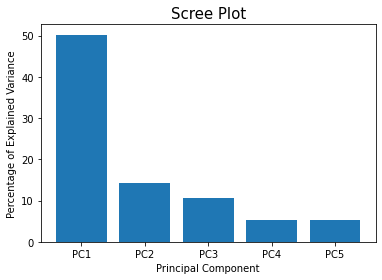

In [59]:
## PCA Scree Plot
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label = labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot', fontsize = 15)

PC1 and PC2 account of 70% of the variation. PC1 is the highest account, which contains almost 50% of the variation

Getting deeper train/test sets

In [60]:
x_train_sparse = x_train.loc[:,sparse_cols].to_numpy()
x_test_sparse = x_test.loc[:,sparse_cols].to_numpy()
val_x_sparse = val_x.loc[:,sparse_cols].to_numpy()

In [61]:
x_train_final = hstack([x_train_pca,x_train_discrete,x_train_sparse])
x_test_final = hstack([x_test_pca,x_test_discrete,x_test_sparse])
val_x_final = hstack([val_x_pca,val_discrete,val_x_sparse])

In [62]:
print(x_train_final.shape)
print(x_test_final.shape)
print(val_x_final.shape)

(21814, 928)
(9349, 928)
(7791, 928)


Logistic Regression

In [63]:
# We create a LogisticRegression model object
# from scikit-learn module.

logreg = LogisticRegression(solver='liblinear', random_state=0)

# fit method estimates the coefficients
logreg.fit(x_train, y_train)

predictions = logreg.predict(x_train)
errors = np.array(y_train) - predictions

# Estimated coefficients.
print('\nCoefficients: \n', logreg.coef_)
print('\nIntercept: \n', logreg.intercept_)


Coefficients: 
 [[ 1.46032125e+00  9.59871308e+00  7.89347889e+00  1.68268597e+00
   5.74509307e+00 -2.25532305e-02 -1.86510872e-02 -1.01331271e-01
   4.96413768e-02  1.94489824e-03  1.43490399e-04  2.01258975e-03
   1.26076836e-01  3.14281530e-02  5.48255658e-01  2.26563552e-01
   4.69237717e-01 -5.65034093e-01  3.17079381e-01  1.83776622e-02
  -1.53624800e-01 -1.93837269e-01  0.00000000e+00  0.00000000e+00
  -7.38913298e+00 -7.91629600e+00 -1.48284784e+01  5.12462731e+00
   2.98239025e+00  8.57143981e-01  5.31366674e-01 -2.45354665e+00
   0.00000000e+00  0.00000000e+00  3.35388335e-02  0.00000000e+00
  -1.00514021e-01]]

Intercept: 
 [-3.1377811]


Make assumptions before performing logistic regression

In [64]:
#Assumption: the error term should be zero on average
print("Mean of the errors in the model is: {}".format(np.mean(errors))) 

Mean of the errors in the model is: 0.008251581553131018


Since the mean is very close to zero, we can assume that the average of the error terms is zero

Text(0.5, 1.0, 'Residual vs. Predicted')

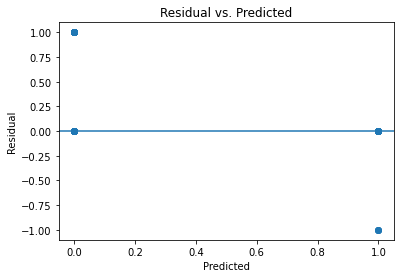

In [65]:
#Assumption: homoscedasticity
#plot
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

In [66]:
#statistical tests
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 30201.4 and p value is 0
Levene test statistic value is 2816.97 and p value is 0


The p-values of both tests are lower than 0.05. As a result, the test result reject the null hupothesis which means our error are heteroscedastic

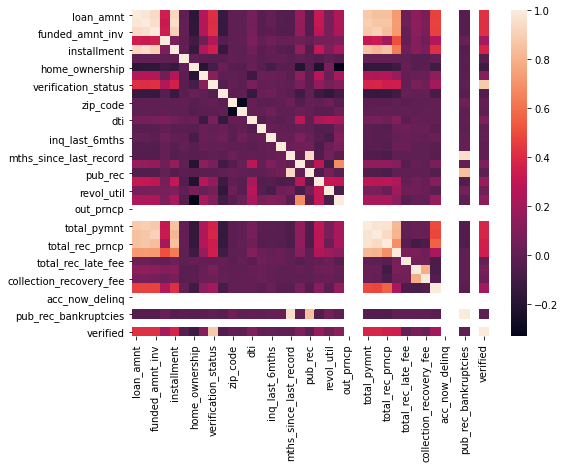

In [67]:
#assumption: low multicollinearit
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(data=x_train.corr())

Some highly correlated features like 
* funded_amnt vs loan_amnt
* funded_amnt vs installment
* installment vs loan_amnt

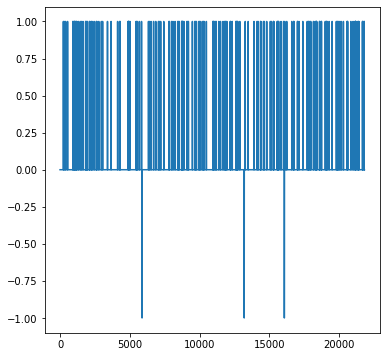

In [68]:
#assumption: error terms should be uncorrelated with one other
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(errors)

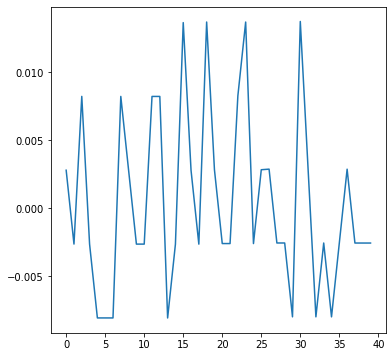

In [69]:
acf_data = acf(errors)
fig, ax = plt.subplots(figsize=(6, 6))
plt.plot(acf_data[1:])

From both plots above, our model are uncorrelated with each others. The autocorrelation between the errors of our medical costs modeled is indeeed very low (from -0.020 to 0.012)

In [70]:
#assumption: features shouldn't be correlated with the errors

df = pd.concat([x_train, pd.DataFrame(errors, columns=["error"])], axis=1)
df.corr().iloc[:,-1:]

,error
loan_amnt,0.004660
funded_amnt,0.005075
funded_amnt_inv,0.005673
term,0.005565
installment,0.002156
emp_length,-0.015121
home_ownership,-0.000278
annual_inc,0.006946
verification_status,-0.004587
purpose,-0.000989


The feature and the errors are uncorrelated

In [71]:
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 11875031.75428477 and p value is 0.0
Normality test statistics is 34089.42434683927 and p value is 0.0


The statistic tests indicate that the data is nomorally distributed

Performing logistic model

In [72]:
#Logistic model
model = LogisticRegression(solver='liblinear', random_state=0).fit(x_train, y_train)

In [73]:
#Present the array of distnct values that y takes
model.classes_

array([0, 1])

In [74]:
#get the value of the slope 𝑏₁ and the intercept 𝑏₀ of the linear function 𝑓 like so:
print("Intercept is: {}".format(model.intercept_))

print('Coefficient is: {}' .format(model.coef_))


Intercept is: [-3.1377811]
Coefficient is: [[ 1.46032125e+00  9.59871308e+00  7.89347889e+00  1.68268597e+00
   5.74509307e+00 -2.25532305e-02 -1.86510872e-02 -1.01331271e-01
   4.96413768e-02  1.94489824e-03  1.43490399e-04  2.01258975e-03
   1.26076836e-01  3.14281530e-02  5.48255658e-01  2.26563552e-01
   4.69237717e-01 -5.65034093e-01  3.17079381e-01  1.83776622e-02
  -1.53624800e-01 -1.93837269e-01  0.00000000e+00  0.00000000e+00
  -7.38913298e+00 -7.91629600e+00 -1.48284784e+01  5.12462731e+00
   2.98239025e+00  8.57143981e-01  5.31366674e-01 -2.45354665e+00
   0.00000000e+00  0.00000000e+00  3.35388335e-02  0.00000000e+00
  -1.00514021e-01]]


In [75]:
#returns the matrix of probabilities that the predicted output is equal to zero or one
model.predict_proba(x_train)

array([[9.99310467e-01, 6.89532958e-04],
       [9.90767369e-01, 9.23263054e-03],
       [9.61256729e-01, 3.87432709e-02],
       ...,
       [9.75370620e-01, 2.46293802e-02],
       [9.99978322e-01, 2.16781697e-05],
       [9.96710498e-01, 3.28950210e-03]])

In [76]:
#the actual predictions, based on the probability matrix and the values of 𝑝(𝑥)
model.predict(x_train)

array([0, 0, 0, ..., 0, 0, 0])

In [77]:
#the accuracy of your model
print("the ratio of the number of correct predictions to the number of observations. is: {}".format(model.score(x_train, y_train)))


the ratio of the number of correct predictions to the number of observations. is: 0.9914733657284313


In [78]:
#get more information on the accuracy of the model with a confusion matrix
#create the confusion matrix
cm = confusion_matrix(y_train, model.predict(x_train))

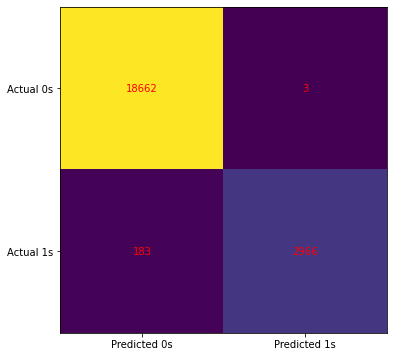

In [79]:
#visuallize the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

In [80]:
print(classification_report(y_train, model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     18665
           1       1.00      0.94      0.97      3149

    accuracy                           0.99     21814
   macro avg       0.99      0.97      0.98     21814
weighted avg       0.99      0.99      0.99     21814




1.   For Precision
* there are 99% charged off as the prediction correctly
* there are 100% full paid as the prediction correctly 
2.   For Recall
* there are 100% positive charged off cases that were catched
* there are 94% positive full paid cases that were catched
3. For F1-score
* there are 100% charged off of positive predictions were correct
* there are 97% paid off of positive predictions were correct


In [81]:
#get more statistical detrails related to model and results
sta_model = sm.Logit(y_train, x_train)

In [82]:
#apply Broyden-Fletcher-Goldfarb-Shanno
result = sta_model.fit(method='bfgs')

         Current function value: 0.051581
         Iterations: 35
         Function evaluations: 44
         Gradient evaluations: 39


In [83]:
result.params

loan_amnt                   6.427023
funded_amnt                 7.988348
funded_amnt_inv             7.244219
term                        2.920578
installment                 6.257657
emp_length                 -0.214412
home_ownership             -0.107833
annual_inc                  0.029327
verification_status        -1.972201
purpose                    -0.111620
zip_code                   -0.003360
addr_state                 -0.045890
dti                         0.382334
delinq_2yrs                -0.002077
inq_last_6mths              0.132173
mths_since_last_delinq     -0.348240
mths_since_last_record      0.299584
open_acc                   -1.190419
pub_rec                     0.100389
revol_bal                  -0.315590
revol_util                 -0.164346
total_acc                  -1.536462
out_prncp                   0.000000
out_prncp_inv               0.000000
total_pymnt                -9.096606
total_pymnt_inv            -8.498543
total_rec_prncp           -15.171274
t

In [84]:
#obtain the probabilities of the predicted outputs being equal to one
result.predict(x_train)

39604    1.363940e-02
35537    4.467121e-03
6361     6.711229e-03
5124     2.200426e-16
5027     1.821206e-03
             ...     
14074    2.634044e-03
7913     2.578819e-03
4172     9.662859e-03
32880    1.038468e-09
29096    1.971778e-04
Length: 21814, dtype: float64

In [85]:
(result.predict(x_train) >= 0.5).astype(int)

39604    0
35537    0
6361     0
5124     0
5027     0
        ..
14074    0
7913     0
4172     0
32880    0
29096    0
Length: 21814, dtype: int64

Mean absolute error (MAE) of the prediction is: 0.023994382880060474
Mean squared error (MSE) of the prediction is: 0.011801744109221524
Root mean squared error (RMSE) of the prediction is: 0.10863583252878178
Mean absolute percentage error (MAPE) of the prediction is: inf


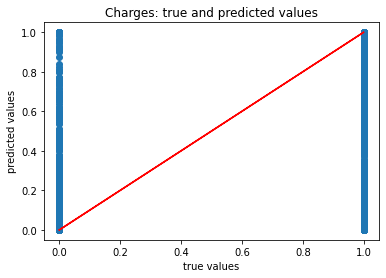

In [86]:
# We are making predictions here
# checking prediction with the train dataset
y_train_preds = result.predict(x_train)

plt.scatter(y_train, y_train_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_train, y_train_preds)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_train, y_train_preds)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_train, y_train_preds)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_train - y_train_preds) / y_train)) * 100))

Mean absolute error (MAE) of the prediction is: 0.022742819612524744
Mean squared error (MSE) of the prediction is: 0.01095905514413081
Root mean squared error (RMSE) of the prediction is: 0.1046855058932745
Mean absolute percentage error (MAPE) of the prediction is: inf


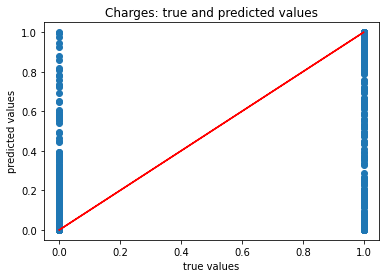

In [87]:
# checking prediction with the test dataset
y_test_preds = result.predict(x_test)

plt.scatter(y_test, y_test_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_test_preds)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_test_preds)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_test_preds)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_test_preds) / y_test)) * 100))

RMSE of test dataset and train dataset are not similar. Need to perform regularization

In [88]:
#create alpha
alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

#lasso regression
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(x_train)
y_preds_test = lasso_cv.predict(x_test)
print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model in training set is: {}".format(lasso_cv.score(x_train, y_train)))
print('\n')
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(lasso_cv.score(x_test, y_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1e-05
R-squared of the model in training set is: 0.5910732460334602


-----Test set statistics-----
R-squared of the model in test set is: 0.6060832796227864
Mean absolute error (MAE) of the prediction is: 0.13479318537109009
Mean squared error (MSE) of the prediction is: 0.04902695130820592
Root mean squared error (RMSE) of the prediction is: 0.2214203046430158
Mean absolute percentage error (MAPE) of the prediction is: inf


In [89]:
#ridge regression
ridge_cv = RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = ridge_cv.predict(x_train)
y_preds_test = ridge_cv.predict(x_test)

print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model in training set is: {}".format(ridge_cv.score(x_train, y_train)))
print('\n')
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(ridge_cv.score(x_test, y_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 1.0
R-squared of the model in training set is: 0.591040331192376


-----Test set statistics-----
R-squared of the model in test set is: 0.6065534326493035
Mean absolute error (MAE) of the prediction is: 0.1347795355580055
Mean squared error (MSE) of the prediction is: 0.04896843597147082
Root mean squared error (RMSE) of the prediction is: 0.221288128853472
Mean absolute percentage error (MAPE) of the prediction is: inf


In [90]:
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5)

elasticnet_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(x_train)
y_preds_test = elasticnet_cv.predict(x_test)

print("Best alpha value is: {}".format(elasticnet_cv.alpha_))
print("R-squared of the model in training set is: {}".format(elasticnet_cv.score(x_train, y_train)))
print('\n')
print("-----Test set statistics-----")
print("R-squared of the model in test set is: {}".format(elasticnet_cv.score(x_test, y_test)))
print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model in training set is: 0.5908336800006647


-----Test set statistics-----
R-squared of the model in test set is: 0.6069869243015835
Mean absolute error (MAE) of the prediction is: 0.13474146063718037
Mean squared error (MSE) of the prediction is: 0.04891448351647349
Root mean squared error (RMSE) of the prediction is: 0.22116618981316627
Mean absolute percentage error (MAPE) of the prediction is: inf


The R-square of the logistic training data set drop from 0.99 to 0.59 in Lasso, Ridge, and Elasticnet. Although MAE, MSE, RMSE, and MAPE are the same, Ridge reregression bring the highest alpha, which fix high variance by encoraging smaller weight.

In [91]:
#Using ridge regression
#lasso regression
lasso_cv = LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(x_train, y_train)

# We are making predictions here
y_preds_train = lasso_cv.predict(x_train)
y_preds_test = lasso_cv.predict(x_test)

In [92]:
## Check accuracy score
print('Accuracy score is: {}' .format('%0.2f' %r2_score(y_test, y_test_preds)))

Accuracy score is: 0.91


In [93]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, y_test_preds)
roc_auc = auc(fp, tp)

Area under the ROC curve: 0.995


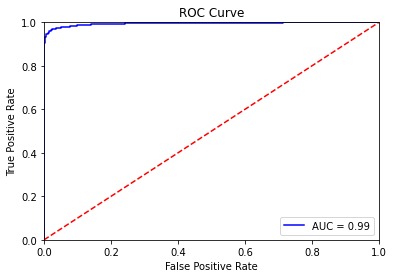

In [94]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc = roc_auc_score(y_test, y_test_preds)
print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.995 means it is the outstanding discrimination

In [95]:
cross_val_score(lasso_cv,x_test,y_test, cv=10)

array([0.64394775, 0.62907101, 0.59879296, 0.62138169, 0.55595261,
       0.62952171, 0.5645535 , 0.61643353, 0.61401717, 0.60312693])

Only 64% accurate

Decision Tree Model

In [96]:
## Create estimator
clf = DecisionTreeClassifier(class_weight='balanced',max_depth=3)

In [97]:
## Fit the model using training set 
clf.fit(x_train_final,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [98]:
#test accuracy
print("R-squared of the model in training set is: {}".format(clf.score(x_train_final,y_train)))
print("R-squared of the model in test set is: {}".format(clf.score(x_test_final,y_test)))

R-squared of the model in training set is: 0.9648849362794536
R-squared of the model in test set is: 0.9632046208150604


Train set and Test set have simnilar R-square. There is no need to do regularization

[Text(697.5, 475.65000000000003, 'X[922] <= 0.0\ngini = 0.5\nsamples = 21814\nvalue = [10907.0, 10907.0]'),
 Text(558.0, 339.75, 'X[3] <= -0.263\ngini = 0.315\nsamples = 19431\nvalue = [10907.0, 2653.148]'),
 Text(279.0, 203.85000000000002, 'X[2] <= -1.108\ngini = 0.142\nsamples = 6129\nvalue = [3531.846, 294.409]'),
 Text(139.5, 67.94999999999999, 'gini = 0.35\nsamples = 1151\nvalue = [641.038, 187.037]'),
 Text(418.5, 67.94999999999999, 'gini = 0.069\nsamples = 4978\nvalue = [2890.808, 107.373]'),
 Text(837.0, 203.85000000000002, 'X[2] <= -1.07\ngini = 0.367\nsamples = 13302\nvalue = [7375.154, 2358.738]'),
 Text(697.5, 67.94999999999999, 'gini = 0.479\nsamples = 2171\nvalue = [1141.247, 755.073]'),
 Text(976.5, 67.94999999999999, 'gini = 0.325\nsamples = 11131\nvalue = [6233.907, 1603.665]'),
 Text(837.0, 339.75, 'gini = 0.0\nsamples = 2383\nvalue = [0.0, 8253.852]')]

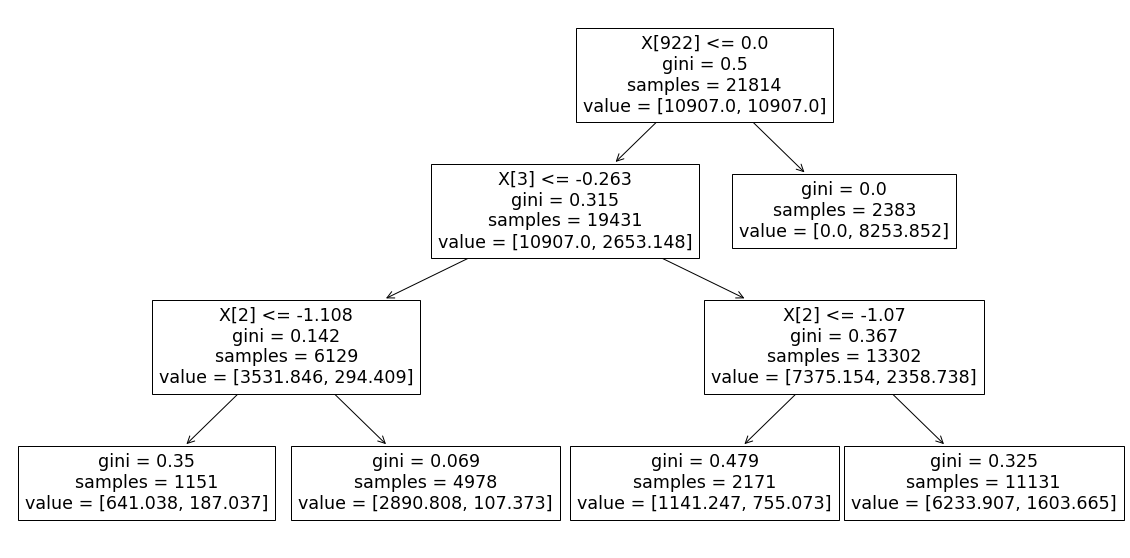

In [99]:
## Decision Tree Plot
plt.figure(figsize=(20,10))
tree.plot_tree(clf)

In [100]:
## Check accuracy score
print('%0.2f' % clf.score(x_test_final,y_test))

0.96


In [101]:
## Predict y given test set
predictions = clf.predict(x_test_final)

In [102]:
## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(y_test,predictions)

array([[7987,    0],
       [ 344, 1018]])

In [103]:
## Accuracy score
print('%0.2f' % precision_score(y_test, predictions))

1.00


In [104]:
## Recall score
print('%0.2f' % recall_score(y_test, predictions))

0.75


In [105]:
## Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      7987
           1       1.00      0.75      0.86      1362

    accuracy                           0.96      9349
   macro avg       0.98      0.87      0.92      9349
weighted avg       0.96      0.96      0.96      9349




1.   For Precision
* there are 96% charged off as the prediction correctly
* there are 100% full paid as the prediction correctly 
2.   For Recall
* there are 100% positive charged off cases that were catched
* there are 75% positive full paid cases that were catched
3. For F1-score
* there are 98% charged off of positive predictions were correct
* there are 86% paid off of positive predictions were correct


In [106]:
# We are making predictions here

y_preds_test = clf.predict(x_test_final)

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Mean absolute error (MAE) of the prediction is: 0.03679537918493957
Mean squared error (MSE) of the prediction is: 0.03679537918493957
Root mean squared error (RMSE) of the prediction is: 0.19182121672260233
Mean absolute percentage error (MAPE) of the prediction is: nan


In [107]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)

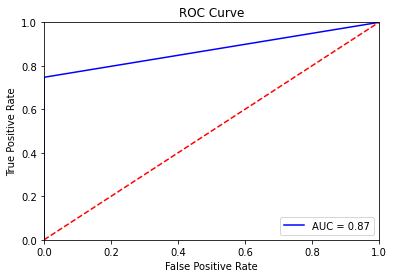

Area under the ROC curve: 0.874


In [108]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

auc = roc_auc_score(y_test, predictions)
print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.874 means it is the outstanding discrimination

In [109]:
cross_val_score(clf, x_test_final, y_test, cv=10)

array([0.96363636, 0.9540107 , 0.96791444, 0.95828877, 0.96470588,
       0.9657754 , 0.96470588, 0.9657754 , 0.95935829, 0.96359743])

In [110]:
## Check accuracy score with validation set
print('%0.2f' % clf.score(val_x_final,val_y))

0.96


In [111]:
## Predict y given test set
predictions = clf.predict(val_x_final)

In [112]:
## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(val_y,predictions)

array([[6662,    0],
       [ 291,  838]])

In [113]:
## Accuracy score
print('%0.2f' % precision_score(val_y, predictions))

1.00


In [114]:
## Recall score
print('%0.2f' % recall_score(val_y, predictions))

0.74


In [115]:
## Print classification report
print(classification_report(val_y, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      6662
           1       1.00      0.74      0.85      1129

    accuracy                           0.96      7791
   macro avg       0.98      0.87      0.92      7791
weighted avg       0.96      0.96      0.96      7791




1.   For Precision
* there are 96% charged off as the prediction correctly
* there are 100% full paid as the prediction correctly 
2.   For Recall
* there are 100% positive charged off cases that were catched
* there are 74% positive full paid cases that were catched
3. For F1-score
* there are 98% charged off of positive predictions were correct
* there are 84% paid off of positive predictions were correct


In [116]:
# We are making predictions here

y_preds_test = clf.predict(val_x_final)

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(val_y, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(val_y, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(val_y, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((val_y - y_preds_test) / val_y)) * 100))

Mean absolute error (MAE) of the prediction is: 0.03735078937235271
Mean squared error (MSE) of the prediction is: 0.03735078937235271
Root mean squared error (RMSE) of the prediction is: 0.19326352312930836
Mean absolute percentage error (MAPE) of the prediction is: nan


In [117]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(val_y, predictions)
auc = roc_auc_score(val_y, predictions)

Area under the ROC curve: 0.871


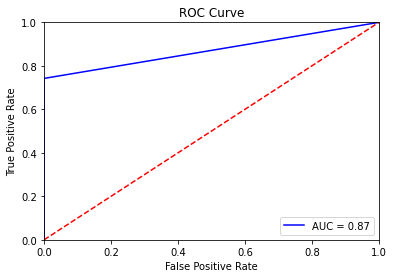

In [118]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

print('Area under the ROC curve: {:.3f}'.format(auc))

Area under the ROC curve: 0.871 means it is the outstanding discrimination

In [119]:
cross_val_score(clf,val_x_final,val_y, cv=10)

array([0.97307692, 0.957638  , 0.96405648, 0.94094994, 0.96405648,
       0.9563543 , 0.96020539, 0.96277279, 0.96277279, 0.96148909])

97% accuracy

In [120]:
## Create the parameter grid based on the results of random search 
params = {'class_weight':['balanced',None],
          'criterion':['gini','entropy'],
          'max_depth':[2,3,4],
          'max_features':['auto','sqrt','log2',None],
          'min_samples_leaf':[1,2,3],
          'min_samples_split':[2,4]
}

In [121]:
## Create estimator
clf = DecisionTreeClassifier()

In [122]:
gs = GridSearchCV(clf,param_grid=params,scoring='recall')

In [123]:
gs.fit(x_train_final,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': ['balanced', None],
              

In [124]:
#test accuracy
print("R-squared of the model in training set is: {}".format(gs.score(x_train_final,y_train)))
print("R-squared of the model in test set is: {}".format(gs.score(x_test_final,y_test)))

R-squared of the model in training set is: 0.08701174976182915
R-squared of the model in test set is: 0.0763582966226138


Train set and Test set are pretty similar. There is no need to do regularization

In [125]:
gs.best_score_

0.7939581598405128

In [126]:
gs.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=2, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [127]:
est = gs.best_estimator_

In [128]:
## Fit the model using training set 
est.fit(x_train_final,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=2, max_features='log2', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [129]:
#test accuracy
print("R-squared of the model in training set is: {}".format(est.score(x_train_final,y_train)))
print("R-squared of the model in test set is: {}".format(est.score(x_test_final,y_test)))

R-squared of the model in training set is: 0.8542220592280187
R-squared of the model in test set is: 0.8533532998181623


Train and test sets have the similar R-square. There is no need to do regularization

In [130]:
## Check accuracy score
print('%0.2f' % est.score(x_test_final,y_test))

0.85


In [131]:
## Predict y given test set
predictions = est.predict(x_test_final)

In [132]:
## Take a look at the confusion matrix ([TN,FN],[FP,TP])
confusion_matrix(y_test,predictions)

array([[7974,   13],
       [1358,    4]])

In [133]:
## Accuracy score
print('%0.2f' % precision_score(y_test, predictions))

0.24


In [134]:
## Recall score
print('%0.2f' % recall_score(y_test, predictions))

0.00


In [135]:
## Print classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92      7987
           1       0.24      0.00      0.01      1362

    accuracy                           0.85      9349
   macro avg       0.54      0.50      0.46      9349
weighted avg       0.76      0.85      0.79      9349




1.   For Precision
* there are 88% charged off as the prediction correctly
* there are 15% full paid as the prediction correctly 
2.   For Recall
* there are 1% positive charged off cases that were catched
* there are 100% positive full paid cases that were catched
3. For F1-score
* there are 1% charged off of positive predictions were correct
* there are 25% paid off of positive predictions were correct

In [136]:
# We are making predictions here

y_preds_test = est.predict(x_test_final)

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Mean absolute error (MAE) of the prediction is: 0.14664670018183762
Mean squared error (MSE) of the prediction is: 0.14664670018183762
Root mean squared error (RMSE) of the prediction is: 0.38294477432371055
Mean absolute percentage error (MAPE) of the prediction is: nan


In [137]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)

Area under the ROC curve: 0.501


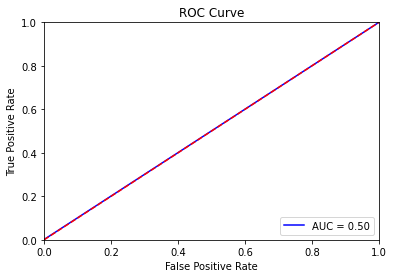

In [138]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc = roc_auc_score(y_test, predictions)
print('Area under the ROC curve: {:.3f}'.format(auc))

In [139]:
cross_val_score(est, x_test_final, y_test, cv=10)

array([0.85454545, 0.62887701, 0.14973262, 0.22352941, 0.15080214,
       0.85026738, 0.53903743, 0.17433155, 0.85240642, 0.26017131])

The score cross validation reports is the accuracy of the tree. Here we're about 66% accurate.

Random Forest

In [140]:
rfc = ensemble.RandomForestClassifier()
X = x_test_final
Y = y_test

In [141]:
#Train the model 
rfc.fit(X,Y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [142]:
#test accuracy
print("R-squared of the model in training set is: {}".format(rfc.score(x_train_final,y_train)))
print("R-squared of the model in test set is: {}".format(rfc.score(x_test_final,y_test)))

R-squared of the model in training set is: 0.9647474099202347
R-squared of the model in test set is: 0.9998930366884159


Train set and data set have a pretty similar R square, there is no need to do regularization

In [143]:
#making prediction
y_pred = rfc.predict(X)

In [144]:
#prin accuracy score
print('%0.2f' % accuracy_score(Y, y_pred))

1.00


In [145]:
## Accuracy score
print('%0.2f' % precision_score(Y, y_pred))

1.00


In [146]:
## Recall score
print('%0.2f' % recall_score(Y, y_pred))

1.00


In [147]:
## Print classification report
print(classification_report(Y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7987
           1       1.00      1.00      1.00      1362

    accuracy                           1.00      9349
   macro avg       1.00      1.00      1.00      9349
weighted avg       1.00      1.00      1.00      9349




1.   For Precision
* there are 100% charged off as the prediction correctly
* there are 100% full paid as the prediction correctly 
2.   For Recall
* there are 100% positive charged off cases that were catched
* there are 100% positive full paid cases that were catched
3. For F1-score
* there are 100% charged off of positive predictions were correct
* there are 100% paid off of positive predictions were correct

In [148]:
# We are making predictions here

y_preds_test = rfc.predict(X)

print("Mean absolute error (MAE) of the prediction is: {}".format(mean_absolute_error(Y, y_preds_test)))
print("Mean squared error (MSE) of the prediction is: {}".format(mse(Y, y_preds_test)))
print("Root mean squared error (RMSE) of the prediction is: {}".format(rmse(Y, y_preds_test)))
print("Mean absolute percentage error (MAPE) of the prediction is: {}".format(np.mean(np.abs((Y - y_preds_test) / Y)) * 100))

Mean absolute error (MAE) of the prediction is: 0.00010696331158412665
Mean squared error (MSE) of the prediction is: 0.00010696331158412665
Root mean squared error (RMSE) of the prediction is: 0.010342306879227992
Mean absolute percentage error (MAPE) of the prediction is: nan


In [149]:
## Get data to plot ROC Curve
fp, tp, th = roc_curve(Y, y_pred)
auc = roc_auc_score(Y, y_pred)

Area under the ROC curve: 1.000


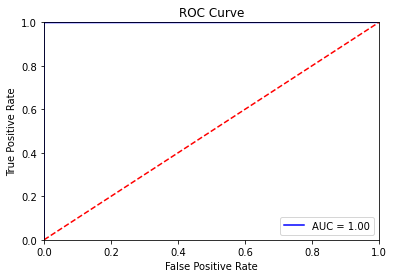

In [150]:
## Plot ROC Curve
plt.title('ROC Curve')
plt.plot(fp, tp, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

auc = roc_auc_score(Y, y_pred)
print('Area under the ROC curve: {:.3f}'.format(auc))

In [151]:
cross_val_score(rfc, X, Y, cv=10)

array([0.96256684, 0.95828877, 0.96791444, 0.95828877, 0.96470588,
       0.96470588, 0.96256684, 0.96470588, 0.95935829, 0.96252677])

The score cross validation reports is the accuracy of the tree. Here we're about 96% accurate.

**Comparing all model:**
1. Logistic model (with the adjust of lasso regression)
* Accuracy score: 0.91
* ROC score: 0.99
* The score cross validation reports are 64%
2. Decision tree with regular train/test set:
* Accuracy score: 0.96
* Recall score 0.75
* ROC score: 0.874
* The score cross validation reports are 94%
3. Decision tree with regular validation train/test set:
* Accuracy score: 0.96
* Recall score 0.74
* ROC score: 0.871
* The score cross validation reports are 97%
4. Decision Tree with (Gridsearch)
* Accuracy score: 0.61
* Recall score 0.40
* ROC score: 0.522
* The score cross validation reports are 82%
5. Random Forest
* Accuracy score: 1.00
* Recall score 1.00
* ROC score: 0.99
* The score cross validation reports are 96%


---
---


**The best model is random forest**